In [1]:
import pandas as pd
import numpy as np
import sqldf
import matplotlib.pyplot as plt
from google.oauth2.service_account import Credentials

In [2]:
#подгружаем все и приводим всё в рабочий вид

In [3]:
transactions = pd.read_csv (r"C:\Users\nignatiev\Desktop\data-pari\xlsx\test\transactions.csv", sep=';')

In [4]:
transactions['standard_cost'] = transactions['standard_cost'].str.replace('$', '', regex=False)

In [5]:
customers = pd.read_csv (r"C:\Users\nignatiev\Desktop\data-pari\xlsx\test\customers.csv", sep=';')

In [6]:
customers['age'] = customers['age'].astype(int)

In [7]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], infer_datetime_format=True)

In [8]:
#выбираем нужные значения, фильтруем по условиям задачи, 

In [9]:
query = """
SELECT transactions.customer_id,
       transactions.standard_cost,
       customers.age,
       customers.owns_car,
       DENSE_RANK() OVER (PARTITION BY transactions.customer_id ORDER BY transactions.brand) AS distinct_rank, -- подсчет уникальных товаров по айдишке
       RANK() OVER (PARTITION BY transactions.customer_id ORDER BY transactions.transaction_date) AS purchases, -- была использована для подсчета покупок по дате транзакции, пригодится для поиска 4 покупки
       transactions.transaction_date
FROM transactions
INNER JOIN customers ON transactions.customer_id = customers.customer_id
WHERE order_status IS 'Approved' AND standard_cost IS NOT NULL
ORDER BY transactions.customer_id, DENSE_RANK() OVER (PARTITION BY transactions.customer_id ORDER BY transactions.brand)
"""

In [10]:
df_view = sqldf.run(query)

In [11]:
df_view

,customer_id,standard_cost,age,owns_car,distinct_rank,purchases,transaction_date
0,1,764.96,69,Yes,1,4,2017-03-29 00:00:00
1,1,829.65,69,Yes,1,7,2017-05-19 00:00:00
2,1,211.37,69,Yes,1,8,2017-06-04 00:00:00
3,1,173.18,69,Yes,1,10,2017-12-14 00:00:00
4,1,270.30,69,Yes,2,1,2017-01-05 00:00:00
...,...,...,...,...,...,...,...
19609,3500,1167.18,55,No,1,6,2017-08-08 00:00:00
19610,3500,874.90,55,No,2,4,2017-03-14 00:00:00
19611,3500,53.62,55,No,3,5,2017-04-25 00:00:00
19612,3500,45.26,55,No,4,2,2017-01-11 00:00:00


In [12]:
df_view['standard_cost'] = pd.to_numeric(df_view['standard_cost'], downcast='float')

In [13]:
#подсчет общего ревенью

In [14]:
revenue_all = df_view['standard_cost'].sum()

In [15]:
revenue_all

10899468.0

In [16]:
#фильтры по условиям задачи — важный пользователь старше 25 и с машиной

In [17]:
df_view_car = df_view.loc[(df_view['owns_car'] == 'Yes')]


In [18]:
df_view_filter = df_view_car.loc[(df_view['age'] > 25)]

In [19]:
revenue_all_filter = df_view_filter['standard_cost'].sum()

In [20]:
#подсчет ревенью пользователей с фильтром

In [21]:
revenue_all_filter

5189018.5

In [22]:
df_view_filter.loc[:, 'unique_things'] = df_view_filter.groupby('customer_id')['distinct_rank'].transform('max')

C:\Users\nignatiev\AppData\Local\Temp\ipykernel_6736\3188069430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_view_filter.loc[:, 'unique_things'] = df_view_filter.groupby('customer_id')['distinct_rank'].transform('max')


In [23]:
df_view_filter

,customer_id,standard_cost,age,owns_car,distinct_rank,purchases,transaction_date,unique_things
0,1,764.960022,69,Yes,1,4,2017-03-29 00:00:00,5
1,1,829.650024,69,Yes,1,7,2017-05-19 00:00:00,5
2,1,211.369995,69,Yes,1,8,2017-06-04 00:00:00,5
3,1,173.179993,69,Yes,1,10,2017-12-14 00:00:00,5
4,1,270.299988,69,Yes,2,1,2017-01-05 00:00:00,5
...,...,...,...,...,...,...,...,...
19603,3499,376.839996,43,Yes,2,7,2017-11-09 00:00:00,4
19604,3499,298.720001,43,Yes,3,1,2017-01-12 00:00:00,4
19605,3499,507.579987,43,Yes,3,4,2017-04-25 00:00:00,4
19606,3499,108.760002,43,Yes,4,2,2017-02-25 00:00:00,4


In [24]:
#подсчет уникальных товаров у важных клиентов

In [25]:
df_view_unique = df_view_filter[['customer_id','unique_things']].copy()

In [26]:
df_view_unique

,customer_id,unique_things
0,1,5
1,1,5
2,1,5
3,1,5
4,1,5
...,...,...
19603,3499,4
19604,3499,4
19605,3499,4
19606,3499,4


In [27]:
df_view_unique = df_view_unique.drop_duplicates(['customer_id', 'unique_things'])

In [28]:
df_view_unique_things_mean = df_view_unique['unique_things'].mean()

In [29]:
df_view_unique_things_mean

3.62969696969697

In [30]:
#подсчет уникальных товаров

In [31]:
df_view['unique_things'] = df_view \
    .groupby('customer_id')['distinct_rank'].transform('max')

In [32]:
df_view

,customer_id,standard_cost,age,owns_car,distinct_rank,purchases,transaction_date,unique_things
0,1,764.960022,69,Yes,1,4,2017-03-29 00:00:00,5
1,1,829.650024,69,Yes,1,7,2017-05-19 00:00:00,5
2,1,211.369995,69,Yes,1,8,2017-06-04 00:00:00,5
3,1,173.179993,69,Yes,1,10,2017-12-14 00:00:00,5
4,1,270.299988,69,Yes,2,1,2017-01-05 00:00:00,5
...,...,...,...,...,...,...,...,...
19609,3500,1167.180054,55,No,1,6,2017-08-08 00:00:00,4
19610,3500,874.900024,55,No,2,4,2017-03-14 00:00:00,4
19611,3500,53.619999,55,No,3,5,2017-04-25 00:00:00,4
19612,3500,45.259998,55,No,4,2,2017-01-11 00:00:00,4


In [33]:
#выбор "не-важных" пользователей — без машины и меньше либо равно 25 годам

In [34]:
df_view_no_car = df_view.loc[(df_view['owns_car'] == 'No')]

In [35]:
df_view_other_users = df_view_no_car.loc[(df_view_no_car['age'] <= 25)]

In [36]:
##подсчет уникальных товаров у не-важных клиентов

In [37]:
df_view_non_unique = df_view_other_users[['customer_id','unique_things']].copy()

In [38]:
df_view_non_unique_things_mean = df_view_non_unique['unique_things'].mean()

In [39]:
df_view_non_unique_things_mean

4.037764350453172

In [40]:
query = """
SELECT *
FROM df_view_filter
"""

In [41]:
df_view = sqldf.run(query)

In [42]:
#работа над поиском 1 или 4-ой покупки для последующего поиска 4 покупки

In [43]:
df_view_filter_4_purchase = df_view_filter.loc[(df_view_filter['purchases'] == 1) | (df_view_filter['purchases'] == 4)]

In [44]:
df_view_filter_4_purchase

,customer_id,standard_cost,age,owns_car,distinct_rank,purchases,transaction_date,unique_things
0,1,764.960022,69,Yes,1,4,2017-03-29 00:00:00,5
4,1,270.299988,69,Yes,2,1,2017-01-05 00:00:00,5
11,2,954.820007,42,Yes,1,1,2017-05-04 00:00:00,2
14,3,1167.180054,69,Yes,1,1,2017-02-23 00:00:00,3
19,3,598.760010,69,Yes,3,4,2017-04-21 00:00:00,3
...,...,...,...,...,...,...,...,...
19590,3496,333.179993,37,Yes,2,4,2017-04-18 00:00:00,3
19591,3496,459.709991,37,Yes,3,1,2017-03-07 00:00:00,3
19594,3497,431.450012,37,Yes,2,1,2017-09-01 00:00:00,2
19604,3499,298.720001,43,Yes,3,1,2017-01-12 00:00:00,4


In [45]:
#с помощью SQL-скрипта ищу 

In [46]:
query = """
SELECT 
    DISTINCT(customer_id), 
    MAX(transaction_date) OVER(partition by customer_id) AS max_date, 
    MIN(transaction_date) OVER(partition by customer_id) AS min_date
FROM df_view_filter_4_purchase
WHERE customer_id IN 
     (SELECT
     customer_id
     FROM df_view_filter_4_purchase
     WHERE purchases = 4)
"""

In [47]:
df_view = sqldf.run(query)

In [48]:
df_view

,customer_id,max_date,min_date
0,1,2017-03-29 00:00:00,2017-01-05 00:00:00
1,3,2017-04-21 00:00:00,2017-02-23 00:00:00
2,5,2017-05-26 00:00:00,2017-03-03 00:00:00
3,6,2017-09-16 00:00:00,2017-01-28 00:00:00
4,9,2017-08-20 00:00:00,2017-02-04 00:00:00
...,...,...,...
1329,3483,2017-04-01 00:00:00,2017-01-03 00:00:00
1330,3484,2017-06-20 00:00:00,2017-02-18 00:00:00
1331,3489,2017-04-07 00:00:00,2017-01-26 00:00:00
1332,3496,2017-04-18 00:00:00,2017-03-07 00:00:00


In [49]:
#перевод даты в перевариваевый формат + подсчет разницы между минимальной и максимальной датой в днях

In [50]:
df_view['max_date'] = pd.to_datetime(df_view['max_date'])
df_view['min_date'] = pd.to_datetime(df_view['min_date'])

In [51]:
df_view['diff_days'] = (df_view['max_date'] - df_view['min_date']) / np.timedelta64 ( 1 , 'D')

In [52]:
df_view_avg_4 = df_view['diff_days'].mean()

In [53]:
df_view_avg_4

160.62668665667167

In [54]:
df_view['diff_days']

0        83.0
1        57.0
2        84.0
3       231.0
4       197.0
        ...  
1329     88.0
1330    122.0
1331     71.0
1332     42.0
1333    103.0
Name: diff_days, Length: 1334, dtype: float64

In [55]:
#тут графики, но не понимаю, почему гитхаб не переваривает первый график, так всё рабочее

Text(0, 0.5, 'Count')

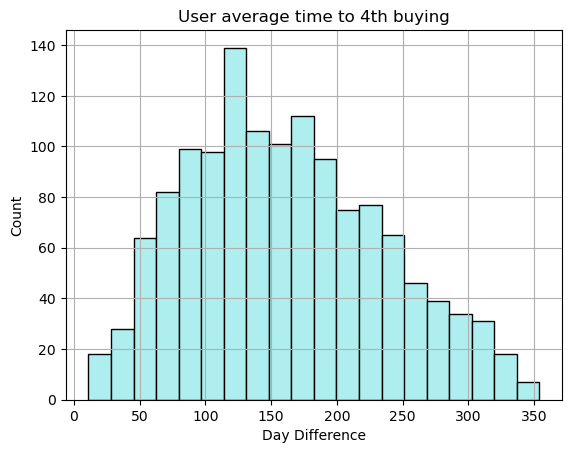

In [56]:
plt.title('User average time to 4th buying')
df_view['diff_days'].hist(bins = 20, edgecolor='black', color='paleturquoise')
plt.xlabel("Day Difference")
plt.ylabel("Count")

In [57]:
labels = ['Rest users','Users 25+ y.o. & have car']
colors = ['thistle','paleturquoise']
values = [revenue_all - revenue_all_filter, revenue_all_filter]
explode = [0,0.1]

([<matplotlib.patches.Wedge at 0x1e7395280a0>,
 [Text(-0.08258380738378172, 1.0968955806082905, 'Rest users'),
  Text(0.09009131420182365, -1.1966133690985523, 'Users 25+ y.o. & have car')],
 [Text(-0.045045713118426395, 0.5983066803317947, '52.4%'),
  Text(0.05255326661773045, -0.6980244653074889, '47.6%')])

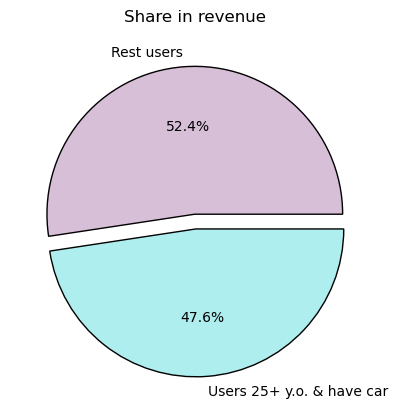

In [58]:
plt.title('Share in revenue')
plt.pie(values, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

In [59]:
labels_2 = ['Rest users','Users 25+ y.o. & have car']
colors_2 = ['thistle','paleturquoise']
values_2 = [round(df_view_non_unique_things_mean, 1), round(df_view_unique_things_mean, 1)]
explode_2 = [0,0.1]

<function matplotlib.pyplot.show(close=None, block=None)>

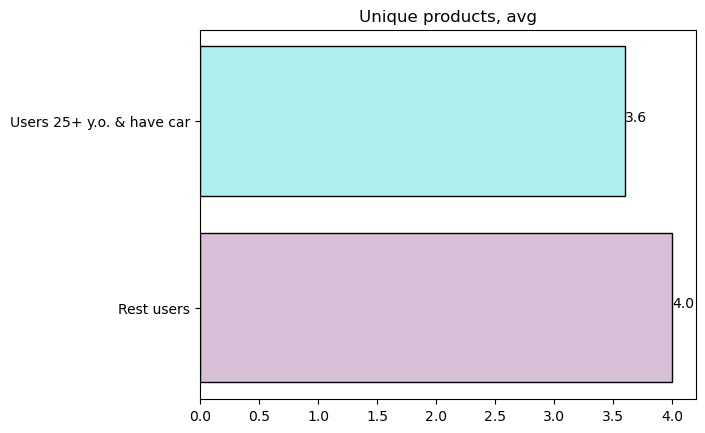

In [60]:
index = np.arange(2)
plt.title('Unique products, avg')
plt.barh(labels_2, values_2, color=['thistle', 'paleturquoise'], edgecolor='black')
for index, value in enumerate(values_2):
    plt.text(value, index, str(value))
plt.show